In [1]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
BSR = 0.5
a = 5
A = BSR / (1 - math.exp(-a))
B = (1 - BSR) / (math.exp(a) - 1)
T = 60 * 60

In [3]:
class FakeTime:
    def __init__(self):
        self.now = 0
    def time(self):
        return self.now
    def sleep(self, T):
        self.now += T

time = FakeTime()

In [24]:
class SuccessGen:
    def __init__(self, rate):
        self.rate = rate
        self.next = time.time() + random.expovariate(rate)
        self.state = int(0.5 < random.random())

    def gen(self):
        now = time.time()
        while now > self.next:
            self.state = 1 - self.state
            self.next = self.next + random.expovariate(self.rate)
        return self.state

class LegacySuccessGen:
    def __init__(self, rate):
        self.rate = rate

    def gen(self):
        now = time.time()
        sr = (math.cos(self.rate/(2*math.pi) * now)) ** 2
        return sr

In [40]:
class Node:
    def __init__(self, rsr):
        self.success_rate = BSR
        self.last_update = time.time()
        self.history = []
        self.real_success_rate = rsr
        self.herstory = []

    def snapshot(self):
        t, sr = self.last_update, self.success_rate
        self.history.append((t, sr))

    def update_success_rate(self):
        dt = time.time() - self.last_update
        sr = self.success_rate
        if dt >= T:
            nsr = BSR
        else:
            if sr <= BSR:
                nsr = A + (sr - A) * math.exp(-a*dt/T)
                nsr = max(nsr, 0)
                nsr = min(nsr, BSR)
            else:
                nsr = (1 + B) + (sr - 1 - B) * math.exp(a*dt/T)
                nsr = max(nsr, BSR)
                nsr = min(nsr, 1)
        self.success_rate = nsr
        self.last_update = time.time()
        self.snapshot()

    def log_success(self):
        self.update_success_rate()
        self.success_rate = 0.5 * (1 + self.success_rate)

    def log_failure(self):
        self.update_success_rate()
        self.success_rate = 0.5 * self.success_rate

    def upload(self):
        p = random.random()
        rsr = self.real_success_rate.gen()
        if p < rsr:
            self.log_success()
        else:
            self.log_failure()
        self.herstory.append((time.time(), rsr))

    def get_success_rate(self):
        self.update_success_rate()
        return self.success_rate

    def show(self):
        ts, srs = [], []
        rts, rsrs = [], []
        for (t, sr) in self.history:
            ts.append(t)
            srs.append(sr)
        for (rt, rsr) in self.herstory:
            rts.append(rt)
            rsrs.append(rsr)
        plt.plot(ts, srs, label="Estimated success rate")
        plt.plot(rts, rsrs, label="Real success rate")
        plt.xlabel("Time")
        plt.ylabel("Success rate")
        plt.title("Quality of success rate estimation")
        plt.legend()
        filename = random.random().hex() + ".png"
        plt.savefig(filename, dpi=600)

    def estimate(self):
        t0 = self.history[0][0]
        t_, sr_ = t0, 0
        s = 0
        for (t, sr) in self.history:
            dt = t - t_
            s += dt * sr_
            t_ = t
            sr_ = sr
        return s / (t_ - t0)

    def simulate(self, N, gen_itt):
        for _ in range(N):
            tau = gen_itt()
            time.sleep(tau)
            p = random.random()
            if p < 0.5:
                self.get_success_rate()
            else:
                self.upload()
            print(".", end="")
        print()
        print("Average success rate: %.2f" % self.estimate())
        self.show()

In [41]:
INTERVAL = T / 60
class MathieuNode(Node):
    def __init__(self, rsr):
        super().__init__(rsr)
        self.failures = 0
        self.successes = 0

    def update_success_rate(self):
        dt = time.time() - self.last_update
        if dt < INTERVAL:
            return
        alpha = math.exp(-dt / T)
        if self.failures + self.successes == 0:
            # sr = BSR
            pass
        else:
            sr = self.successes / (self.failures + self.successes)
            self.success_rate = alpha * sr + (1 - alpha) * self.success_rate
        self.failures = 0
        self.successes = 0
        self.last_update = time.time()
        self.snapshot()

    def log_failure(self):
        self.failures += 1
        self.update_success_rate()

    def log_success(self):
        self.successes += 1
        self.update_success_rate()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

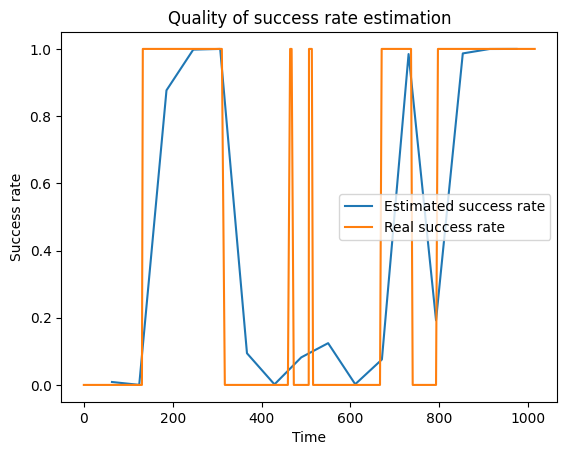

In [43]:
time = FakeTime()
rsr = SuccessGen(1/60)
# rsr = LegacySuccessGen(1/20)

def gen_itt():
    mean = 1
    return random.expovariate(mean)
DUR = 1000
mnode = MathieuNode(rsr)
mnode.simulate(DUR, gen_itt)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

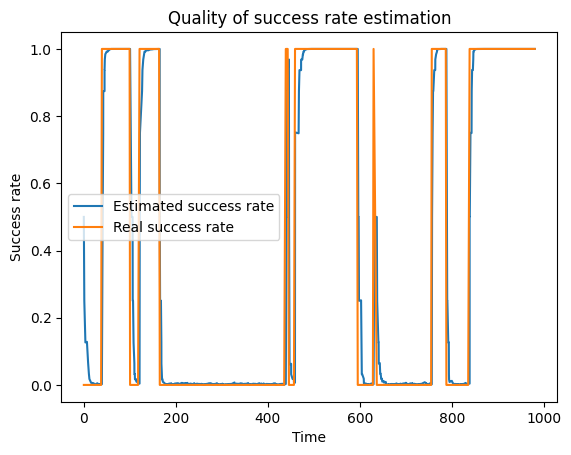

In [44]:
time = FakeTime()
rsr = SuccessGen(1/60)
time = FakeTime()
node = Node(rsr)
node.simulate(DUR, gen_itt)

In [22]:
a = 5
def sr1(t):
    A = BSR / (1 - math.exp(-a))
    return A * (1 - math.exp(-a*t/T))
def sr2(sr, dt):
    A = BSR / (1 - math.exp(-a))
    if dt > T:
        return BSR
    else:
        nsr = A + (sr - A) * math.exp(-a*dt/T)
        if nsr < 0:
            return 0
        elif nsr > BSR:
            return BSR
        else:
            return nsr

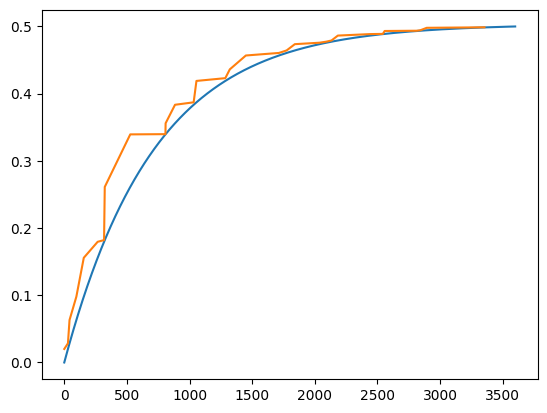

In [26]:
ts = np.arange(0, T, 0.1)
srs = [sr1(t) for t in ts]
plt.plot(ts, srs)

ts, srs = [], []
t, sr = 0, 0
mean = 100
while t < T:
    dt = random.expovariate(1/mean)
    if t + dt > T:
        break
    nsr = sr2(sr, dt)
    srs.append(nsr)
    ts.append(t)
    t += dt
    sr = nsr
plt.plot(ts, srs)

In [36]:
random.random().hex()

'0x1.4bf9532c9bf78p-2'